<a href="https://colab.research.google.com/github/pasumarthi/EVA/blob/master/Session7/Assignment_7b_80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input,Lambda
from keras.layers.advanced_activations import ReLU, Softmax
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import keras

Using TensorFlow backend.


In [0]:
#https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/  Should try grid search

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

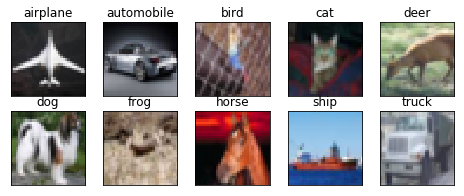

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_bs2(x):
  return tf.space_to_depth(x, block_size=2)

def space_to_depth_bs4(x):
  return tf.space_to_depth(x, block_size=4)

In [8]:
## MAIN BLOCK
from keras.layers import Activation


x1 = Input(shape=(32,32,3))


x2=SeparableConv2D(16, (5,5), padding='same',  use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x1)#32
x2 = ReLU()(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(32, (5,5), padding='same', use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x2)#32
x3 = ReLU()(x3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.2)(x3)

x4 = Conv2D(32, (5,5), padding='same', use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x3)#32
x4 = ReLU()(x4)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.2)(x4)


x4_x5= Concatenate(axis=-1)([x4,x2])
x5=SeparableConv2D(32, (5,5), padding='same',  use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x4_x5)#32
x5 = ReLU()(x2)
x5 = BatchNormalization()(x5)
x5 = Dropout(0.5)(x5)

##block2
x2_block2 = Lambda(space_to_depth_bs2)(x2)
x3_block2 = Lambda(space_to_depth_bs2)(x3)
x4_block2 = Lambda(space_to_depth_bs2)(x4)
x5_block2 = Lambda(space_to_depth_bs2)(x5)



x5 = Conv2D(16, (1,1), padding='same', use_bias=False)(x5)#32
x2_x5= Concatenate(axis=-1)([x2,x5])
#x2_x5 = Conv2D(32, (1,1), padding='same', use_bias=False)(x2_x5)#32
x6 =  MaxPooling2D(pool_size=(2, 2))(x2_x5) #16

x7=SeparableConv2D(16, (3,3), padding='same',  use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x6)#16
x7 = ReLU()(x7)
x7 = BatchNormalization()(x7)
x7 = Dropout(0.4)(x7)

x2_x5_x7=Concatenate(axis=-1)([x2_block2,x5_block2,x7])
x8= Conv2D(32, (5,5), padding='same', use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x2_x5_x7)#16
x8 = ReLU()(x8)
x8 = BatchNormalization()(x8)
x8 = Dropout(0.3)(x8)

x8_x4_x5_x7=Concatenate(axis=-1)([x8,x4_block2,x5_block2,x7])
x9=SeparableConv2D(32, (3,3), padding='same',  use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x8_x4_x5_x7)#16
x9 = ReLU()(x9)
x9 = BatchNormalization()(x9)

x9_x8_x7_x5_x4_x2=Concatenate(axis=-1)([x2_block2,x4_block2,x5_block2,x7,x8,x9])
x10=SeparableConv2D(32, (5,5), padding='same',  use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x9_x8_x7_x5_x4_x2)#
x10 = ReLU()(x10)
x10 = BatchNormalization()(x10)
x10 = Dropout(0.4)(x10)


x10 = Conv2D(16, (1,1), padding='same', use_bias=False)(x10)
x10_x9_x7_x5_x2=Concatenate(axis=-1)([x2_block2,x5_block2,x7,x9,x10])

#x10_x9_x7_x5_x2 = Conv2D(16, (1,1), padding='same', use_bias=False)(x10_x9_x7_x5_x2)
x11=MaxPooling2D(pool_size=(2, 2))(x10_x9_x7_x5_x2)#8
## block3
x2_block3 = Lambda(space_to_depth_bs4)(x2)
x3_block3 = Lambda(space_to_depth_bs4)(x3)
x4_block3 = Lambda(space_to_depth_bs4)(x4)
x5_block3 = Lambda(space_to_depth_bs4)(x5)

x7_block3 = Lambda(space_to_depth_bs2)(x7)
x8_block3 = Lambda(space_to_depth_bs2)(x8)
x9_block3 = Lambda(space_to_depth_bs2)(x9)
x10_block3 = Lambda(space_to_depth_bs2)(x10)


x11_x8=Concatenate(axis=-1)([x8_block3,x11])
x12=Conv2D(16, (5,5), padding='same', use_bias=False,kernel_regularizer=regularizers.l2(0.02))(x11_x8)#8
x12 = ReLU()(x12)
x12 = BatchNormalization()(x12)
x12 = Dropout(0.4)(x12)

x12_x9_x5_x3=Concatenate(axis=-1)([x3_block3,x5_block3,x9_block3,x12])
x13=SeparableConv2D(16, (5,5), padding='same',  use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x12_x9_x5_x3)#
x13 = ReLU()(x13)
x13 = BatchNormalization()(x13)
x13 = Dropout(0.5)(x13)

x13_x12_x7_x4_x3=Concatenate(axis=-1)([x3_block3,x4_block3,x7_block3,x12,x13])
x14=Conv2D(32, (5,5), padding='same', use_bias=False,kernel_regularizer=regularizers.l2(0.01))(x13_x12_x7_x4_x3)#8
x14 = ReLU()(x14)
x14 = BatchNormalization()(x14)
x14 = Dropout(0.3)(x14)

x14_x13_x9_x7_x5_x4_x2=Concatenate(axis=-1)([x2_block3,x4_block3,x5_block3,x7_block3,x9_block3,x13,x14])
x15=SeparableConv2D(64, (5,5), padding='same',  use_bias=False,kernel_regularizer=regularizers.l2(0.02))(x14_x13_x9_x7_x5_x4_x2)#8
x15 = ReLU()(x15)



x15_x13_x9_x5=Concatenate(axis=-1)([x5_block3,x9_block3,x13,x15])


reduce_ch = Conv2D(10, (1,1), use_bias=False)(x15_x13_x9_x5)#8
avg_pool = GlobalAveragePooling2D()(reduce_ch)
output = Softmax()(avg_pool)
"""
reduce_ch = Conv2D(10, (8,8), use_bias=False)(x15_x13_x9_x5)#8
x16 = Flatten()(reduce_ch)
output = Softmax()(x16)
"""


model = Model(inputs=[x1], outputs=[output])

#print(datetime.datetime.now())

W0619 03:05:31.325517 140427571681152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 03:05:31.338454 140427571681152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 03:05:31.342792 140427571681152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 03:05:31.373708 140427571681152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 03:05:31.374873 1404275716

In [0]:
"""
from keras import backend as K

def l1_reg(weight_matrix):
    return 0.01 * K.sum(K.abs(weight_matrix))

model.add(Dense(64, input_dim=64,
                kernel_regularizer=l1_reg))
                """

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 16)   123         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 16)   0           separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          re_lu_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [0]:
"""
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
  if (epoch <= 3 ):
   return 0.003
  elif(epoch <=6):
   return 0.002
  elif(epoch <=9):
   return 0.001
  elif(epoch <=13):
   return 0.0005 
  else: 
   return round(0.001 * 1/(1 + 0.319 * epoch), 10)
   import keras.callback
   """
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, mode='min',min_lr=0.003)
#model.fit(X_train, Y_train, callbacks=[reduce_lr])


In [14]:
from google.colab import drive
drive.mount('/content/gdrive')
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/EVA/Session7\\saveBest.hdf7"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='auto', save_best_only=True, save_weights_only=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
390/390 [==============================] - 38s 96ms/step - loss: 1.2552 - acc: 0.5876 - val_loss: 1.2157 - val_acc: 0.6038

Epoch 00001: val_acc improved from -inf to 0.60380, saving model to /content/gdrive/My Drive/EVA/Session7\saveBest.hdf7
Epoch 2/50
390/390 [==============================] - 34s 88ms/step - loss: 1.1188 - acc: 0.6369 - val_loss: 1.0932 - val_acc: 0.6496

Epoch 00002: val_acc improved from 0.60380 to 0.64960, saving model to /content/gdrive/My Drive/EVA/Session7\saveBest.hdf7
Epoch 3/50
390/390 [==============================] - 34s 87ms/step - loss: 1.0366 - acc: 0.6677 - val_loss: 1.1147 - val_acc: 0.6439

Epoch 00003: val_acc did not improve from 0.64960
Epoch 4/50
390/390 [==============================] - 34s 87ms/step - loss: 0.9743 - acc: 0.6934 - val_loss: 1.0999 - val_acc: 0.6498

Epoch 00004: val_acc improved from 0.64960 to 0.64980, saving model to /content/gdrive/My Drive/EVA/Session7\saveBest.hdf7
Epoch 5/50
390/390 [========================

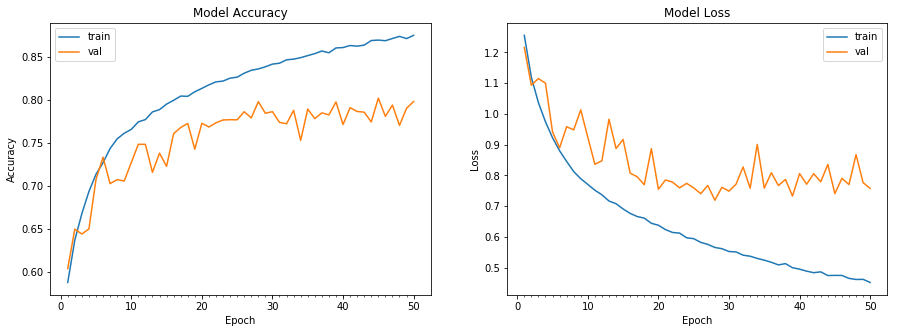

Accuracy on test data is: 79.80


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#datagen   = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.125,height_shift_range=0.125)
datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False)


#lr1=LearningRateScheduler(scheduler, verbose=1)
start = time.time()

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[reduce_lr,checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train" %(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))



